In [ ]:
import scanpy as sc
import pertpy as pt
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import matplotlib.pyplot as plt
import pertpy as pt

/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/yumm-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("/home/icb/raphael.kfuri-rubens/data/yumm_analysis/anndata_files/immunity_dc_revision_annotation_v6.h5ad")

# Top 100 genes immune vs non-immune

In [3]:
adata.obs["annotation_v6"].value_counts(dropna=False)

annotation_v6
Non-immune cells               11771
Inflam-TAMs                     3374
Reg-TAMs                        2744
Mono-DCs                        2508
Classical Monocytes             2284
M2-like TAMs                    2058
Tissue-resident TAMs            1674
CCR7+ DCs                        946
cDC2s                            862
Neutrophils                      827
Eosinophils                      771
NK cells                         670
Conventional CD4+ T cells        540
Prolif-TAMs                      532
B cells                          486
Tregs                            316
Osteoclast-like giant cells      246
CD8+ T Cells                     220
ISG15+ Monocytes                 214
cDC1s                            171
gamma/delta T cells              151
pDCs                             115
iNKT cells                        98
Basophils/Mast cells              48
Plasma cells                      47
Name: count, dtype: int64

In [ ]:
adata.obs["binary_annotation"] = adata.obs["annotation_v6"].apply(
    lambda x: "nonimmune" 
    if x in ["Non-immune cells", "Osteoclast-like giant cells"] 
    else "immune"
)
adata.obs["binary_annotation"].value_counts(dropna=False)

binary_annotation
immune       21656
nonimmune    12017
Name: count, dtype: int64

In [5]:
sc.tl.rank_genes_groups(adata, groupby="binary_annotation", method="wilcoxon")
gene_groups = sc.get.rank_genes_groups_df(adata, group = None)
gene_groups_subset = gene_groups.groupby("group").head(100)
gene_groups_subset.to_csv('./top_100_degs_immune_vs_non_immune.csv')

/tmp/ipykernel_877441/1498894860.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_groups_subset = gene_groups.groupby("group").head(100)


In [ ]:
counts_raw = adata.obs.groupby(["annotation_v6", "genotype"]).size().unstack(fill_value=0)
counts_props = counts_raw.div(counts_raw.sum(axis=0), axis=1)*100
counts_raw.to_csv("cell_counts_per_genotype_raw.csv")
counts_props.to_csv("cell_counts_per_genotype_props.csv")

/tmp/ipykernel_877441/1770854391.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_raw = adata.obs.groupby(["annotation_v6", "genotype"]).size().unstack(fill_value=0)


In [ ]:
adata.obs["sample_id_genotype"] = adata.obs["sample_id"].astype(str) + "_" + adata.obs["genotype"].astype(str)
coda_raw = adata.obs.groupby(["annotation_v6", "sample_id_genotype"]).size().unstack(fill_value=0)
coda_props = coda_raw.div(coda_raw.sum(axis=0), axis=1)*100
coda_raw.to_csv("cell_counts_per_sample_id_raw.csv")
coda_props.to_csv("cell_counts_per_sample_id_props.csv")

/tmp/ipykernel_877441/1532675018.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coda_raw = adata.obs.groupby(["annotation_v6", "sample_id_genotype"]).size().unstack(fill_value=0)


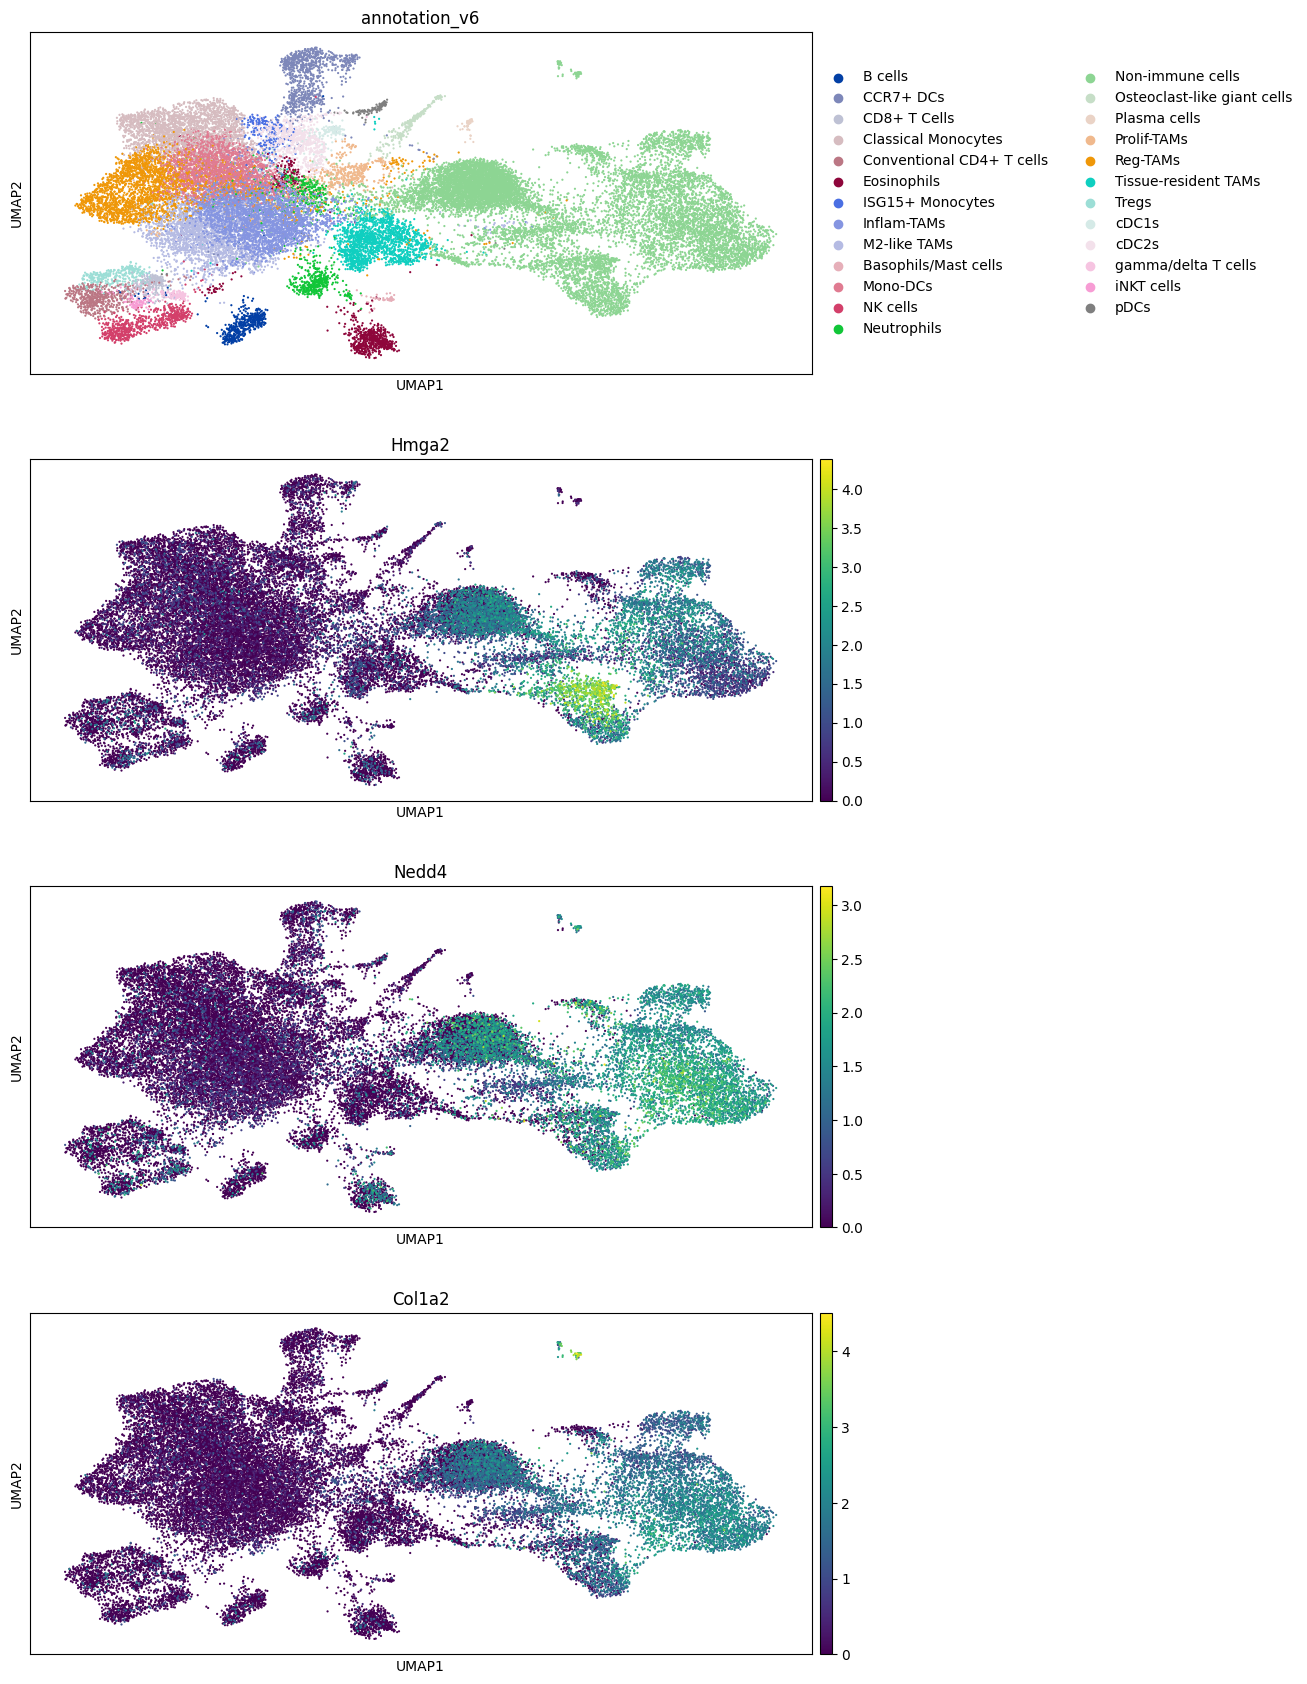

In [ ]:
sc.pl.umap(adata, color=["annotation_v6", "Hmga2", "Nedd4", "Col1a2"], wspace=0.7, size=10, ncols=1)

In [ ]:
colors_dict = dict(zip(adata.uns["annotation_v6_colors"], adata.uns["annotation_v6_categories"]))

# scCODA

In [ ]:
sccoda = pt.tl.Sccoda()
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="annotation_v6",
    sample_identifier="sample_id",
    covariate_obs=["genotype"],
)
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)

MuData object with n_obs × n_vars = 33681 × 23701
  var:	'n_cells'
  2 modalities
    rna:	33673 x 23676
      obs:	'library_id', 'sample_id', 'genotype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_counts', 'log1p_n_counts', 'log1p_n_genes', 'percent_hb', 'n_counts_hb', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_top50', 'cell_passed_qc', 'consensus_fraction', 'qc_cluster', 'cluster_passed_qc', 'consensus_passed_qc', 'cell_passed_qc_int', 'cluster_passed_qc_int', 'consensus_passed_qc_int', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00', 'annotation_v1_subannot', 'annotation_DC_fine', 'myeloid_fine', 'DC_fine', 'annotation_T_NK_fine', 'annotation_v2', 'annotation_MacMono_fine', 'annotation_v3', 'annotation_v4', 'annotation_b_sep', 'annotation_v5', 'annotation_v6', 'scCODA_sample_id'
      var:	'ensembl_ids', 'gene_symbols', 'n_cells', 'hb', 'mito', 'ribo', 'n_counts', 'highly_variable', 'means', 'disp

/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/pertpy-env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/pertpy-env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/pertpy-env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/pertpy-env/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may w

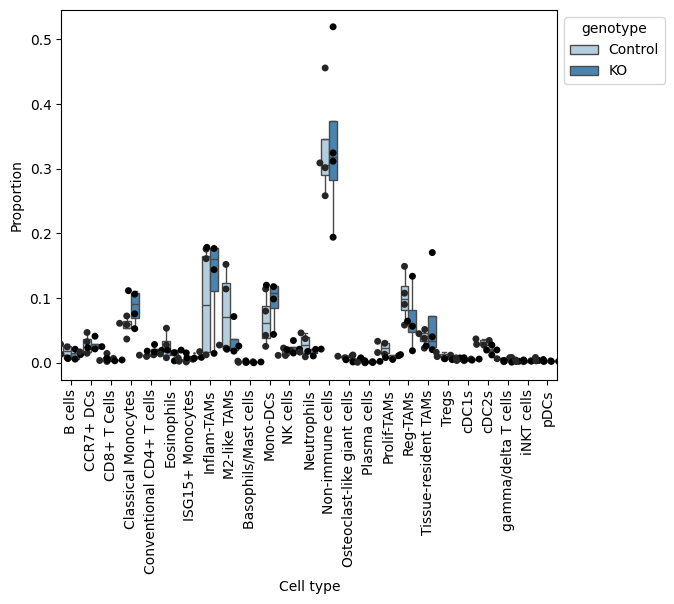

In [24]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda", feature_name="genotype", add_dots=True)
plt.show()

In [ ]:
sccoda_df = pd.DataFrame(
    sccoda_data["coda"].X,
    columns=sccoda_data["coda"].var.index,
    index=sccoda_data["coda"].obs.index
).T
sccoda_df

scCODA_sample_id,S10,S13,S2,S4,S5,S7,S8,S9
annotation_v6,,,,,,,,
B cells,21.0,23.0,90.0,115.0,53.0,48.0,60.0,76.0
CCR7+ DCs,80.0,166.0,54.0,67.0,223.0,171.0,100.0,85.0
CD8+ T Cells,10.0,17.0,13.0,8.0,99.0,25.0,32.0,16.0
Classical Monocytes,340.0,451.0,223.0,234.0,251.0,264.0,246.0,275.0
Conventional CD4+ T cells,54.0,73.0,43.0,56.0,67.0,45.0,132.0,70.0
Eosinophils,63.0,12.0,50.0,31.0,366.0,101.0,91.0,57.0
ISG15+ Monocytes,49.0,34.0,5.0,28.0,17.0,20.0,36.0,25.0
Inflam-TAMs,572.0,59.0,642.0,640.0,84.0,63.0,672.0,642.0
M2-like TAMs,83.0,289.0,100.0,90.0,781.0,555.0,84.0,76.0


In [43]:
sccoda_df_props = sccoda_df.div(sccoda_df.sum(axis=0), axis=1)*100
sccoda_df_props

scCODA_sample_id,S10,S13,S2,S4,S5,S7,S8,S9
annotation_v6,,,,,,,,
B cells,0.655226,0.568744,2.463054,2.892354,0.774401,1.315789,1.285072,2.091935
CCR7+ DCs,2.496100,4.104847,1.477833,1.685111,3.258328,4.687500,2.141786,2.339664
CD8+ T Cells,0.312012,0.420376,0.355774,0.201207,1.446523,0.685307,0.685372,0.440407
Classical Monocytes,10.608424,11.152324,6.102901,5.885312,3.667446,7.236842,5.268794,7.569502
Conventional CD4+ T cells,1.684867,1.805143,1.176793,1.408451,0.978960,1.233553,2.827158,1.926782
Eosinophils,1.965679,0.296736,1.368363,0.779678,5.347750,2.768640,1.949025,1.568951
ISG15+ Monocytes,1.528861,0.840752,0.136836,0.704225,0.248393,0.548246,0.771043,0.688137
Inflam-TAMs,17.847114,1.458952,17.569787,16.096579,1.227352,1.726974,14.392804,17.671346
M2-like TAMs,2.589704,7.146390,2.736727,2.263581,11.411455,15.213816,1.799100,2.091935


In [20]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="genotype",
    reference_cell_type="automatic",
)
sccoda_data["coda"]

• Automatic reference selection! Reference cell type set to iNKT cells
• Zero counts encountered in data! Added a pseudocount of 0.5.


AnnData object with n_obs × n_vars = 8 × 25
    obs: 'genotype', 'sample_id'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [21]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

sample: 100%|██████████| 11000/11000 [00:56<00:00, 195.72it/s, 127 steps of size 3.84e-02. acc. prob=0.85]


AnnData object with n_obs × n_vars = 8 × 25
    obs: 'genotype', 'sample_id'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_genotype[T.KO]'

In [22]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 25 cell types                                    │
│ Reference cell type                         │ iNKT cells                                                        │
│ Formula                                     │ genotype                                                          │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                              Final Parameter  Expected Sample                                                   │
│ Cell Type                                                                                                       │
│ B cells                           0.330            77.896                                                       │
│ CCR7+ DCs                         0.845           130.370                                                       │
│ CD8+ T Cells                     -0.308            41.156                                                       │
│ Classical Monocytes               1.674           298.682                                                       │
│ Conventional CD4+ T cells         0.431            86.175                                                       │
│ Eosinophils                       0.459            88.622                                                       │
│ ISG15+ Monocytes                 -0.250            43.614                                                       │
│ Inflam-TAMs                       1.644           289.855                                                       │
│ M2-like TAMs                      1.309           207.344                                                       │
│ Basophils/Mast cells             -1.010            20.397                                                       │
│ Mono-DCs                          1.701           306.856                                                       │
│ NK cells                          0.560            98.040                                                       │
│ Neutrophils                       0.644           106.632                                                       │
│ Non-immune cells                  3.212          1390.446                                                       │
│ Osteoclast-like giant cells      -0.139            48.734                                                       │
│ Plasma cells                     -1.019            20.214                                                       │
│ Prolif-TAMs                       0.392            82.879                                                       │
│ Reg-TAMs                          1.840           352.616                                                       │
│ Tissue-resident TAMs              1.230           191.594                                                       │
│ Tregs                             0.017            56.962                                                       │
│ cDC1s                            -0.282            42.241                                                       │
│ cDC2s                             0.833           128.815                                                       │
│ gamma/delta T cells              -0.486            34.446                                                       │
│ iNKT cells                       -0.568            31.734                                                       │
│ pDCs                             -0.531            32.930                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                           Final Parameter  Expected Sample  log2-fold change                    │
│ Covariate    Cell Type                                                                                          │
│ genotypeT.KO B cells                          0.000             77.896           0.000                          │
│              CCR7+ DCs                        0.000            130.370           0.000                          │
│              CD8+ T Cells                     0.000             41.156           0.000                          │
│              Classical Monocytes              0.000            298.682           0.000                          │
│              Conventional CD4+ T cells        0.000             86.175           0.000                          │
│              Eosinophils                      0.000             88.622           0.000                          │
│              ISG15+ Monocytes                 0.000             43.614           0.000                          │
│              Inflam-TAMs                      0.000            289.855           0.000                          │
│              M2-like TAMs                     0.000            207.344           0.000                          │
│              Basophils/Mast cells             0.000             20.397           0.000                          │
│              Mono-DCs                         0.000            306.856           0.000                          │
│              NK cells                         0.000             98.040           0.000                          │
│              Neutrophils                      0.000            106.632           0.000                          │
│              Non-immune cells                 0.000           1390.446           0.000                          │
│              Osteoclast-like giant cells      0.000             48.734           0.000                          │
│              Plasma cells                     0.000             20.214           0.000                          │
│              Prolif-TAMs                      0.000             82.879           0.000                          │
│              Reg-TAMs                         0.000            352.616           0.000                          │
│              Tissue-resident TAMs             0.000            191.594           0.000                          │
│              Tregs                            0.000             56.962           0.000                          │
│              cDC1s                            0.000             42.241           0.000                          │
│              cDC2s                            0.000            128.815           0.000                          │
│              gamma/delta T cells              0.000             34.446           0.000                          │
│              iNKT cells                       0.000             31.734           0.000                          │
│              pDCs                             0.000             32.930           0.000                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate       Cell Type                  
genotype[T.KO]  B cells                        False
                CCR7+ DCs                      False
                CD8+ T Cells                   False
                Classical Monocytes            False
                Conventional CD4+ T cells      False
                Eosinophils                    False
                ISG15+ Monocytes               False
                Inflam-TAMs                    False
                M2-like TAMs                   False
                Basophils/Mast cells           False
                Mono-DCs                       False
                NK cells                       False
                Neutrophils                    False
                Non-immune cells               False
                Osteoclast-like giant cells    False
                Plasma cells                   False
                Prolif-TAMs                    False
                Reg-TAMs                       False
  

In [25]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.4)
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 25 cell types                                    │
│ Reference cell type                         │ iNKT cells                                                        │
│ Formula                                     │ genotype                                                          │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                              Final Parameter  Expected Sample                                                   │
│ Cell Type                                                                                                       │
│ B cells                           0.330            77.896                                                       │
│ CCR7+ DCs                         0.845           130.370                                                       │
│ CD8+ T Cells                     -0.308            41.156                                                       │
│ Classical Monocytes               1.674           298.682                                                       │
│ Conventional CD4+ T cells         0.431            86.175                                                       │
│ Eosinophils                       0.459            88.622                                                       │
│ ISG15+ Monocytes                 -0.250            43.614                                                       │
│ Inflam-TAMs                       1.644           289.855                                                       │
│ M2-like TAMs                      1.309           207.344                                                       │
│ Basophils/Mast cells             -1.010            20.397                                                       │
│ Mono-DCs                          1.701           306.856                                                       │
│ NK cells                          0.560            98.040                                                       │
│ Neutrophils                       0.644           106.632                                                       │
│ Non-immune cells                  3.212          1390.446                                                       │
│ Osteoclast-like giant cells      -0.139            48.734                                                       │
│ Plasma cells                     -1.019            20.214                                                       │
│ Prolif-TAMs                       0.392            82.879                                                       │
│ Reg-TAMs                          1.840           352.616                                                       │
│ Tissue-resident TAMs              1.230           191.594                                                       │
│ Tregs                             0.017            56.962                                                       │
│ cDC1s                            -0.282            42.241                                                       │
│ cDC2s                             0.833           128.815                                                       │
│ gamma/delta T cells              -0.486            34.446                                                       │
│ iNKT cells                       -0.568            31.734                                                       │
│ pDCs                             -0.531            32.930                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                           Final Parameter  Expected Sample  log2-fold change                    │
│ Covariate    Cell Type                                                                                          │
│ genotypeT.KO B cells                           0.000            78.359            0.009                         │
│              CCR7+ DCs                         0.000           131.145            0.009                         │
│              CD8+ T Cells                      0.000            41.401            0.009                         │
│              Classical Monocytes               0.000           300.457            0.009                         │
│              Conventional CD4+ T cells         0.000            86.687            0.009                         │
│              Eosinophils                       0.000            89.149            0.009                         │
│              ISG15+ Monocytes                  0.000            43.873            0.009                         │
│              Inflam-TAMs                       0.224           364.841            0.332                         │
│              M2-like TAMs                     -0.184           173.497           -0.257                         │
│              Basophils/Mast cells              0.000            20.518            0.009                         │
│              Mono-DCs                          0.000           308.680            0.009                         │
│              NK cells                          0.000            98.623            0.009                         │
│              Neutrophils                       0.000           107.265            0.009                         │
│              Non-immune cells                  0.000          1398.711            0.009                         │
│              Osteoclast-like giant cells       0.000            49.024            0.009                         │
│              Plasma cells                      0.000            20.334            0.009                         │
│              Prolif-TAMs                       0.000            83.371            0.009                         │
│              Reg-TAMs                         -0.196           291.508           -0.275                         │
│              Tissue-resident TAMs              0.000           192.733            0.009                         │
│              Tregs                             0.000            57.300            0.009                         │
│              cDC1s                             0.000            42.492            0.009                         │
│              cDC2s                             0.000           129.581            0.009                         │
│              gamma/delta T cells               0.000            34.650            0.009                         │
│              iNKT cells                        0.000            31.922            0.009                         │
│              pDCs                              0.000            33.126            0.009                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [26]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate       Cell Type                  
genotype[T.KO]  B cells                        False
                CCR7+ DCs                      False
                CD8+ T Cells                   False
                Classical Monocytes            False
                Conventional CD4+ T cells      False
                Eosinophils                    False
                ISG15+ Monocytes               False
                Inflam-TAMs                     True
                M2-like TAMs                    True
                Basophils/Mast cells           False
                Mono-DCs                       False
                NK cells                       False
                Neutrophils                    False
                Non-immune cells               False
                Osteoclast-like giant cells    False
                Plasma cells                   False
                Prolif-TAMs                    False
                Reg-TAMs                        True
  

/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/yumm-env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/yumm-env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/yumm-env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/yumm-env/lib/python3.10/site-packages/pertpy/tools/_coda/_base_coda.py:1708: UserWarning: FixedFormatter should only be used together w

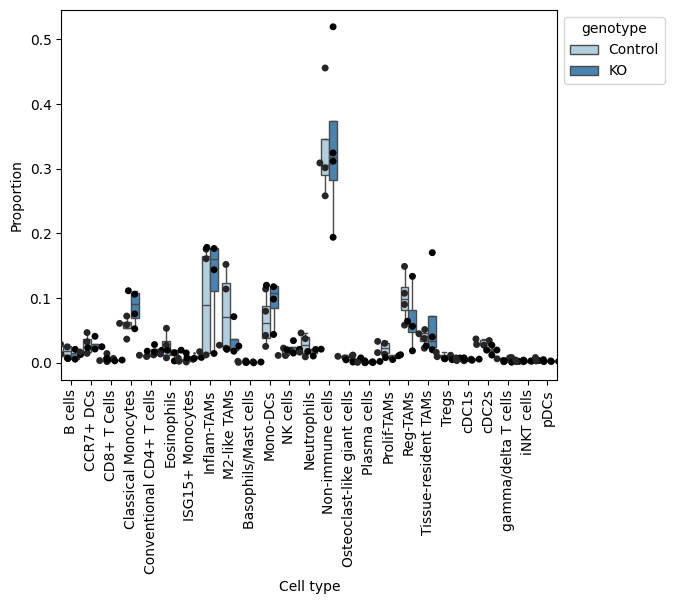

In [35]:
sccoda.plot_boxplots(sccoda_data, modality_key="coda", feature_name="genotype", add_dots=True)
plt.show()

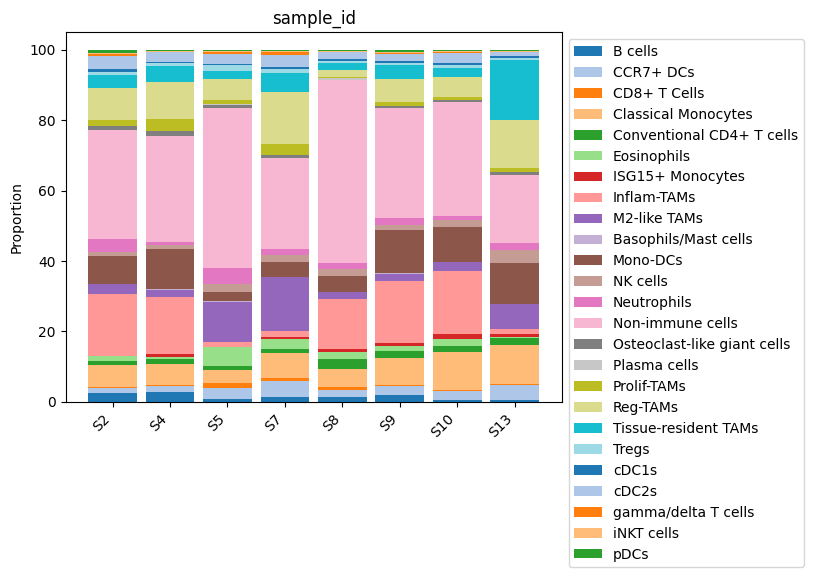

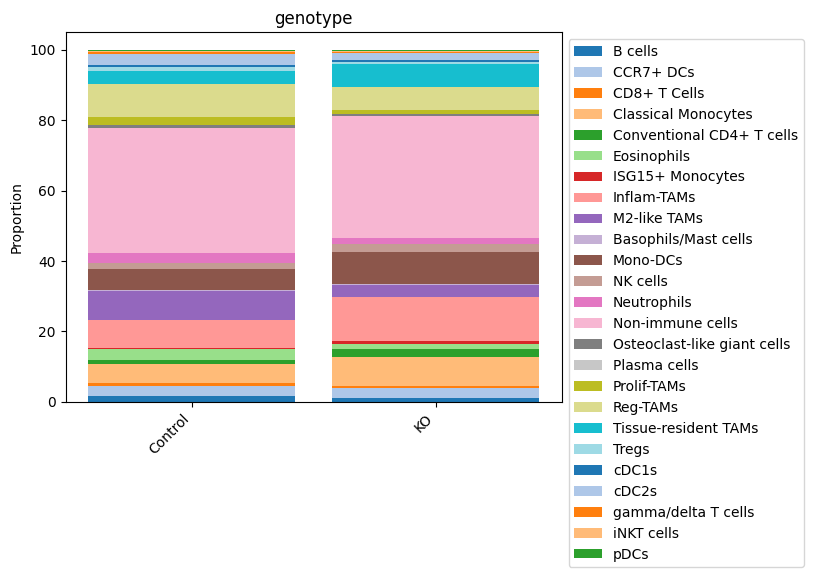

In [36]:
sccoda.plot_stacked_barplot(sccoda_data, modality_key="coda", feature_name="sample_id")
plt.show()

sccoda.plot_stacked_barplot(sccoda_data, modality_key="coda", feature_name="genotype")
plt.show()

<Axes: xlabel='Presence', ylabel='Total dispersion'>

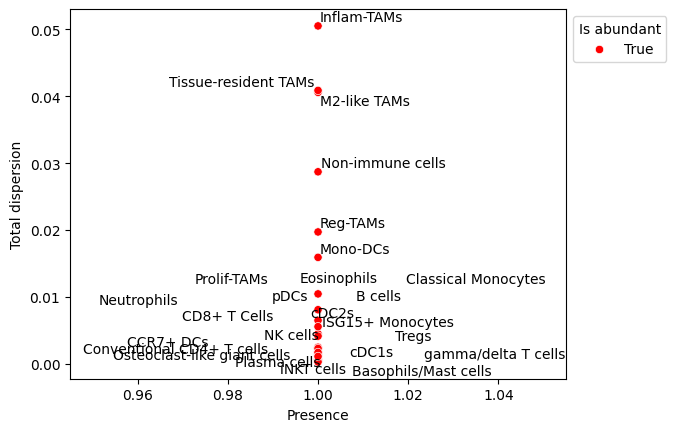

In [ ]:
sccoda.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda", abundant_threshold=0.9)

# milo

In [3]:
milo = pt.tl.Milo()
mdata = milo.load(adata)

In [4]:
mdata

MuData object with n_obs × n_vars = 33673 × 23676
  2 modalities
    rna:	33673 x 23676
      obs:	'library_id', 'sample_id', 'genotype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_counts', 'log1p_n_counts', 'log1p_n_genes', 'percent_hb', 'n_counts_hb', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_top50', 'cell_passed_qc', 'consensus_fraction', 'qc_cluster', 'cluster_passed_qc', 'consensus_passed_qc', 'cell_passed_qc_int', 'cluster_passed_qc_int', 'consensus_passed_qc_int', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00', 'annotation_v1_subannot', 'annotation_DC_fine', 'myeloid_fine', 'DC_fine', 'annotation_T_NK_fine', 'annotation_v2', 'annotation_MacMono_fine', 'annotation_v3', 'annotation_v4', 'annotation_b_sep', 'annotation_v5', 'annotation_v6'
      var:	'ensembl_ids', 'gene_symbols', 'n_cells', 'hb', 'mito', 'ribo', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'DC_fine_colors', 'annotation_DC_fine_colors', 'annotation_MacMono_fine_colors', 'annotation_T_NK_fine_colors', 'annotation_b_sep_colors', 'annotation_v1_subannot_colors', 'annotation_v2_colors', 'annotation_v3_colors', 'annotation_v4_colors', 'annotation_v5_colors', 'annotation_v6_colors', 'genotype_colors', 'hvg', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_1.00', 'leiden_res_2.00', 'library_id_colors', 'log1p', 'myeloid_fine_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'qc_cluster_colors', 'rank_genes_groups', 'sample_id_colors', 'scautoqc_ranges', 'scrublet', 'umap'
      obsm:	'X_pca', 'X_umap', 'X_umap_qc'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [5]:
sc.pp.neighbors(mdata["rna"], use_rep="X_pca", n_neighbors=150)

In [6]:
milo.make_nhoods(mdata["rna"], prop=0.1)

In [7]:
mdata = milo.count_nhoods(mdata, sample_col="sample_id")

In [ ]:
mdata["rna"].obs["genotype"] = mdata["rna"].obs["genotype"].cat.reorder_categories(["Control", "KO"])
milo.da_nhoods(mdata, design="~genotype", model_contrasts="genotypeKO", solver="pydeseq2")

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.54 seconds.

Fitting dispersion trend curve...
/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/pertpy-env/lib/python3.11/site-packages/pydeseq2/dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.52 seconds.

Fitting LFCs...
... done in 0.51 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype KO vs Control
       baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
0     51.918732       -1.008409  0.721229 -1.398181  1.620586e-01  0.430673
1     48.079653       -0.879211  0.578781 -1.519074  1.287438e-01  0.386564
2     28.417902       -0.139703  0.643481 -0.217105  8.281265e-01       NaN
3     39.379446       -0.972899  0.782341 -1.243574  2.136564e-01  0.500630
4     89.526825       -0.820543  0.948214 -0.865357  3.868429e-01  0.666931
...         ...             ...       ...       ...           ...       ...
1421  94.221405        0.723551  0.677051  1.068681  2.852136e-01  0.571411
1422  64.284977        4.018787  0.776162  5.177767  2.245572e-07  0.000196
1423  30.914244       -0.532350  0.608075 -0.875467  3.813197e-01       NaN
1424  99.643673        0.960941  0.712208  1.349241  1.772596e-01  0.455698
1425  31.045557        1.496937  0.751663  1.991499  4.642607e-02       NaN

[1426 rows x 6 columns]


... done in 0.62 seconds.



In [19]:
milo.build_nhood_graph(mdata)

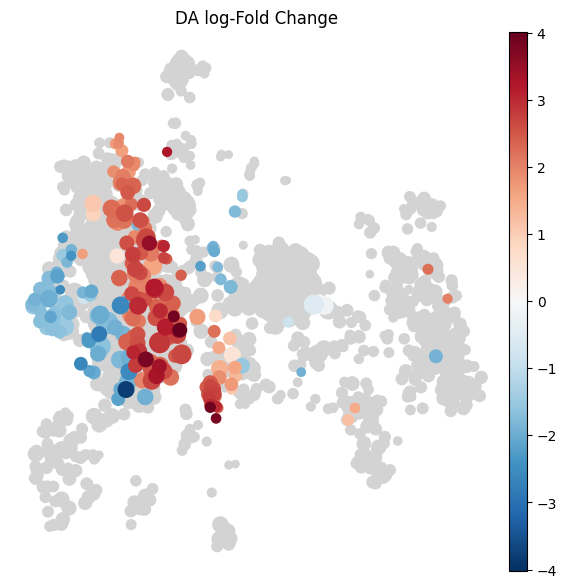

In [ ]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,
    min_size=1,
)

In [24]:
milo.annotate_nhoods(mdata, anno_col="annotation_v6")

In [25]:
mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

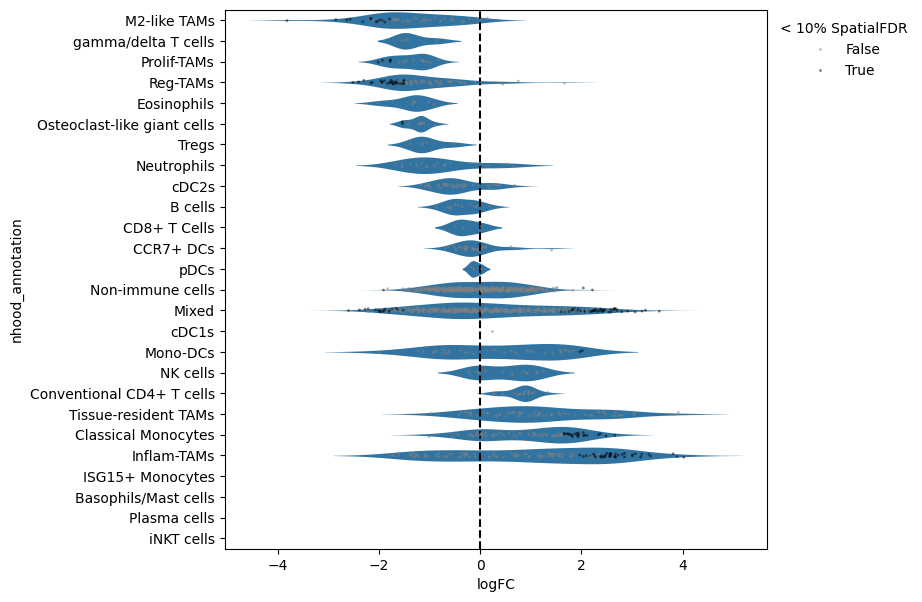

In [26]:
milo.plot_da_beeswarm(mdata, alpha=0.1)